In [1]:
# Importing modules

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

/Users/asimmahat/.local/share/virtualenvs/stock_market_prediction-uzxGUPKk/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
file_path = 'dataset/ibm.csv'  
data = pd.read_csv(file_path)

print(data.head())

                        Date      Open      High       Low     Close  Volume  \
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  1.513320  407940   
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  1.526548  305955   
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  1.511336  274575   
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  1.481573  384405   
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  1.453794  572685   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


#### Data preprocessing 

In [3]:
data_filtered = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Convert 'Date' to datetime format
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])

# Sort data by Date if necessary
data_filtered = data_filtered.sort_values(by='Date')

# Display the cleaned dataset
print(data_filtered.head())

                        Date      Open      High       Low     Close  Volume
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  1.513320  407940
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  1.526548  305955
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  1.511336  274575
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  1.481573  384405
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  1.453794  572685


/var/folders/pm/789pwcn13sv2z1_3b5spk1fw0000gn/T/ipykernel_1119/2156123366.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])
/var/folders/pm/789pwcn13sv2z1_3b5spk1fw0000gn/T/ipykernel_1119/2156123366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])


In [4]:
# Save the cleaned dataset to a new CSV file if needed
data_filtered.to_csv('dataset/cleaned_ibm_data.csv', index=False)

In [5]:
# data_filtered

In [6]:
data_cleaned = data_filtered.dropna()

In [7]:
# data_cleaned 

# initial result -- no null values

In [8]:
# Load the cleaned dataset (after removing nulls and unnecessary columns)
file_path = 'dataset/cleaned_ibm_data.csv'  # Your cleaned dataset file
data = pd.read_csv(file_path)

data.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02 00:00:00-05:00,1.530517,1.530517,1.513320,1.513320,407940
1,1962-01-03 00:00:00-05:00,1.513320,1.526548,1.513320,1.526548,305955
2,1962-01-04 00:00:00-05:00,1.526548,1.526548,1.510674,1.511336,274575
3,1962-01-05 00:00:00-05:00,1.509353,1.509353,1.478927,1.481573,384405
4,1962-01-08 00:00:00-05:00,1.480251,1.480251,1.441889,1.453794,572685


In [9]:
# Prepare data: for Only 'Close' price is used for prediction
data_close = data['Close'].values

#creating column vector ( N rows and 1 column)
data_close = data_close.reshape(-1, 1) 

data_close

array([[  1.51332045],
       [  1.52654803],
       [  1.51133561],
       ...,
       [219.3500061 ],
       [219.72999573],
       [221.49000549]])

In [10]:
# Normalize the data using MinMaxScaler 

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_close)

In [11]:
data_scaled.shape
# the output means using 15797 rows of data with one feature that is "closing price"

(15797, 1)

The output (15797,1) means using 15797 rows of data with one feature that is "closing price"

In [12]:
# #final check for null values
# if np.isnan(data_scaled).any():
#     raise ValueError("NaN values found in the dataset. Please clean the data.")

In [13]:
len(data_scaled)

15797

### Preparing data to feed into LSTM model

In [14]:
# Create a function to prepare sequences of data for LSTM
# def create_sequences(data, time_step):
#     X, y = [], []
#     for i in range(len(data) - time_step - 1):
#         X.append(data[i:(i + time_step), 0])
#         y.append(data[i + time_step, 0])
#     return np.array(X), np.array(y)

In [15]:
import numpy as np

def create_sequences(data, time_step):
    X = np.array([data[i:i + time_step, 0] for i in range(len(data) - time_step - 1)])
    y = np.array([data[i + time_step, 0] for i in range(len(data) - time_step - 1)])
    return X, y


In [16]:
time_step = 60

X, y = create_sequences(data_scaled, time_step)

# again making sure that the X and y are numpy array
# X = np.array(X) 
# y = np.array(y)

In [17]:
X.shape

(15736, 60)

In [18]:
X

array([[0.00316013, 0.00321955, 0.00315122, ..., 0.00286391, 0.00286094,
        0.00273911],
       [0.00321955, 0.00315122, 0.00301752, ..., 0.00286094, 0.00273911,
        0.00277477],
       [0.00315122, 0.00301752, 0.00289274, ..., 0.00273911, 0.00277477,
        0.00275694],
       ...,
       [0.78018095, 0.78739484, 0.78222932, ..., 0.99011771, 1.        ,
        0.98836585],
       [0.78739484, 0.78222932, 0.7882854 , ..., 1.        , 0.98836585,
        0.98944395],
       [0.78222932, 0.7882854 , 0.79037832, ..., 0.98836585, 0.98944395,
        0.98167288]])

In [19]:
# Reshape the input to be [samples, time steps, features]

X = X.reshape(X.shape[0], X.shape[1], 1)
X.shape

(15736, 60, 1)

In [20]:
X.shape

(15736, 60, 1)

In [21]:
y.shape

(15736,)

In [22]:
# Split the data into training and test sets (80% train, 20% test)

train_size = int(len(X) * 0.8)
print(train_size)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

12588


In [23]:
X_train.shape

(12588, 60, 1)

In [24]:
X_test.shape

(3148, 60, 1)

In [25]:
# LSTM model 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2)) 
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

/Users/asimmahat/.local/share/virtualenvs/stock_market_prediction-uzxGUPKk/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=30)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0010
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.4152e-04
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.3890e-04
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.2746e-04
Epoch 5/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.3545e-04
Epoch 6/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.3287e-04
Epoch 7/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.3090e-04
Epoch 8/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.3035e-04
Epoch 9/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.2329e-04
Epoch 10/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1376e-04
Epoch 11/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.2364e-04
Epoch 12/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.2474e-04
Epoch 13/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1784e-04
Epoch 14/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.

In [28]:
# Predict stock prices on the test set
predicted_stock_price = model.predict(X_test)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [29]:
# getting actual stock price by inverse transforming the actual predicted stock price 

predicted_stock_price_original = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

#### Calculating Error Metrices (MSE, RMSE and MAE)

In [30]:
# getting modules from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predicted_stock_price_original)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predicted_stock_price)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 12.984950387167626
Root Mean Squared Error (RMSE): 3.6034636653042065
Mean Absolute Error (MAE): 113.74389572072363


In [31]:
#getting the actual date value before plotting
# data['Date'] = pd.to_datetime(data['Date'])
dates = data['Date'].values 

# train_dates = dates[:train_size] 
# test_dates = dates[train_size:]


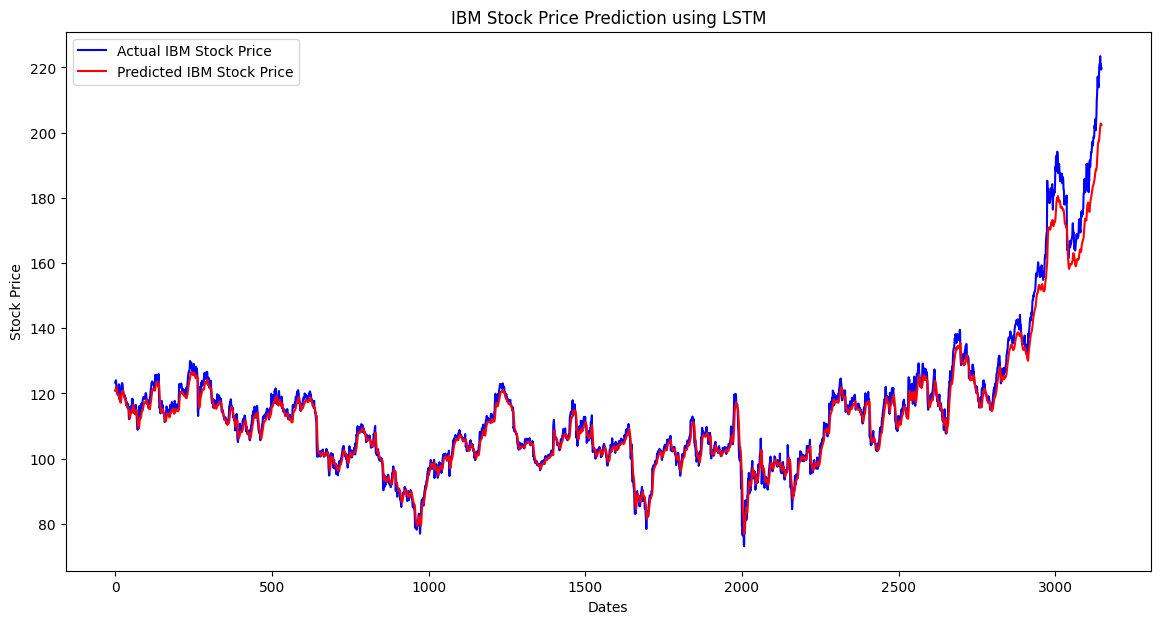

In [32]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='blue', label='Actual IBM Stock Price')
plt.plot(predicted_stock_price_original, color='red', label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction using LSTM')
plt.xlabel('Dates')
plt.ylabel('Stock Price')
plt.legend()
plt.show()